In [76]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import RegularGridInterpolator

def set_tick_format(ax, cbar, decimals=2):
    """
    Set the number of decimal places for x and y ticks on the axis and colorbar.
    """
    formatter = ticker.FormatStrFormatter(f'%.{decimals}f')
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    cbar.ax.yaxis.set_major_formatter(formatter)

def exact_solution(x, y, t):
    """
    Compute exact solution for the Klein-Gordon equation
    """
    return (x + y) * np.cos(t) + x * y * np.sin(t)

def interpolate_to_reference_grid(data, nx_ref, ny_ref, nt_ref, x_ref, y_ref, t_ref):
    """Interpolate solution to reference grid"""
    nx = data.shape[0]
    ny = data.shape[1]
    nt = data.shape[2]
    
    # Create source grid points
    x = np.linspace(L_range[0], L_range[1], nx)
    y = np.linspace(H_range[0], H_range[1], ny)
    t = np.linspace(T_range[0], T_range[1], nt)
    
    # Create interpolator
    interpolator = RegularGridInterpolator((x, y, t), data)
    
    # Create target grid points
    XX, YY, TT = np.meshgrid(x_ref, y_ref, t_ref, indexing='ij')
    points = np.stack([XX.ravel(), YY.ravel(), TT.ravel()], axis=1)
    
    # Interpolate
    return interpolator(points).reshape(nx_ref, ny_ref, nt_ref)
    
# Load the numerical solutions
pikan_data = np.load('./data/2d_kg_pikan_nx50_ny50_nt50_epochs50000_k3.npy', allow_pickle=True).item()
spikan1_data = np.load('./data/2d_kg_spikan_nx100_ny100_nt100_epochs50000_k3_r10.npy', allow_pickle=True).item()
spikan2_data = np.load('./data/2d_kg_spikan_nx150_ny150_nt150_epochs50000_k3_r10.npy', allow_pickle=True).item()
spikan3_data = np.load('./data/2d_kg_spikan_nx200_ny200_nt200_epochs50000_k3_r10.npy', allow_pickle=True).item()

# Plotting setup
plt.rcParams.update({
    'font.size': 14,               
    'axes.titlesize': 14,          
    'axes.labelsize': 14,          
    'xtick.labelsize': 14,         
    'ytick.labelsize': 14,         
    'legend.fontsize': 14,         
})

# Extract domain information from reference (PIKAN) solution
nx = pikan_data['mesh']['nx']
ny = pikan_data['mesh']['ny']
nt = pikan_data['mesh']['nt']
L_range = pikan_data['mesh']['L_range']
H_range = pikan_data['mesh']['H_range']
T_range = pikan_data['mesh']['T_range']

# Create reference grid
x = np.linspace(L_range[0], L_range[1], nx)
y = np.linspace(H_range[0], H_range[1], ny)
t = np.linspace(T_range[0], T_range[1], nt)
X, Y = np.meshgrid(x, y, indexing='ij')

# Interpolate SPIKAN solutions to PIKAN grid
spikan1_interp = interpolate_to_reference_grid(spikan1_data['field_variables']['u_pred'], 
                                             nx, ny, nt, x, y, t)
spikan2_interp = interpolate_to_reference_grid(spikan2_data['field_variables']['u_pred'], 
                                             nx, ny, nt, x, y, t)
spikan3_interp = interpolate_to_reference_grid(spikan3_data['field_variables']['u_pred'], 
                                             nx, ny, nt, x, y, t)

# Solutions dictionary with interpolated solutions
solutions = {
    'PIKAN': pikan_data['field_variables']['u_pred'],
    'SPIKAN (a)': spikan1_interp,
    'SPIKAN (b)': spikan2_interp,
    'SPIKAN (c)': spikan3_interp
}

# Compute exact solution for all time steps
u_exact = np.zeros((nx, ny, nt))
for i, t_val in enumerate(t):
    u_exact[:,:,i] = exact_solution(X, Y, t_val)

# Compute and print global L2 errors
for name, u_pred in solutions.items():
    l2_error = 100 * np.sqrt(np.mean((u_pred - u_exact)**2)) / np.sqrt(np.mean(u_exact**2))
    print(f"L2 Error ({name}): {l2_error:.3f}")

# Time points for plotting
t_plot_values = [0.0, 5.0, 10.0]
t_plot_indices = [int(t * (nt-1)/T_range[1]) for t in t_plot_values]

# Create figure
fig = plt.figure(figsize=(25, 18))
gs = gridspec.GridSpec(len(t_plot_values), 4, width_ratios=[1, 1, 1, 1], wspace=0.3, hspace=0.3)



L2 Error (PIKAN): 2.158
L2 Error (SPIKAN (a)): 1.002
L2 Error (SPIKAN (b)): 0.756
L2 Error (SPIKAN (c)): 0.799


<Figure size 2500x1800 with 0 Axes>

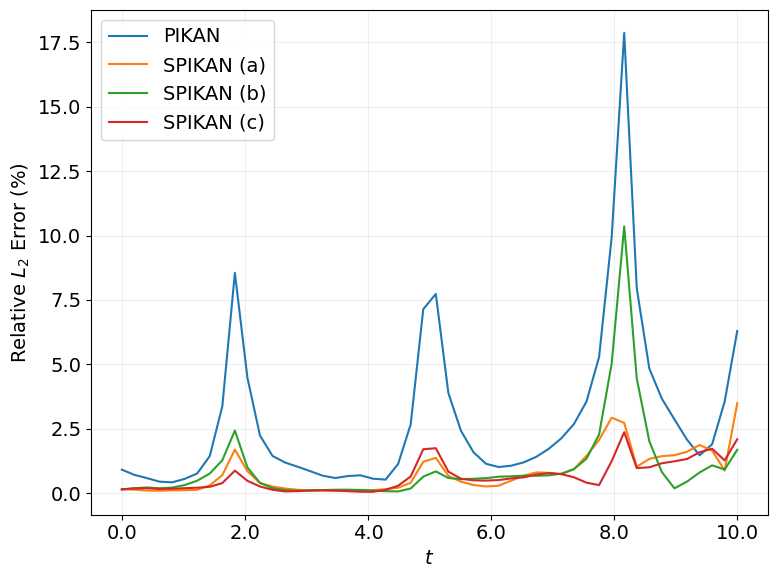

In [80]:
# Plot L2 error evolution over time
fig, ax = plt.figure(figsize=(8, 6)), plt.gca()
for name, sol in solutions.items():
    l2_errors = []
    for i in range(nt):
        # Calculate relative L2 error as percentage
        l2_error = 100 * np.sqrt(np.mean((sol[:,:,i] - u_exact[:,:,i])**2)) / np.sqrt(np.mean(u_exact[:,:,i]**2))
        l2_errors.append(l2_error)
    
    # Convert l2_errors to numpy array for proper plotting
    l2_errors = np.array(l2_errors)
    plt.plot(t, l2_errors, label=name)  # Use t for actual time values

# Format ticks to 2 decimal places
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

plt.grid(True, alpha=0.2)
plt.xlabel(r'$t$')
plt.ylabel(r'Relative $L_2$ Error (%)')
# plt.title(r'Relative $L_2$ Error vs $t$')
plt.legend()
plt.tight_layout()
plt.savefig('./results/l2_error_evolution_2d.png', dpi=600, bbox_inches='tight')
plt.show()

In [86]:
1.836734693877551

np.float64(1.836734693877551)

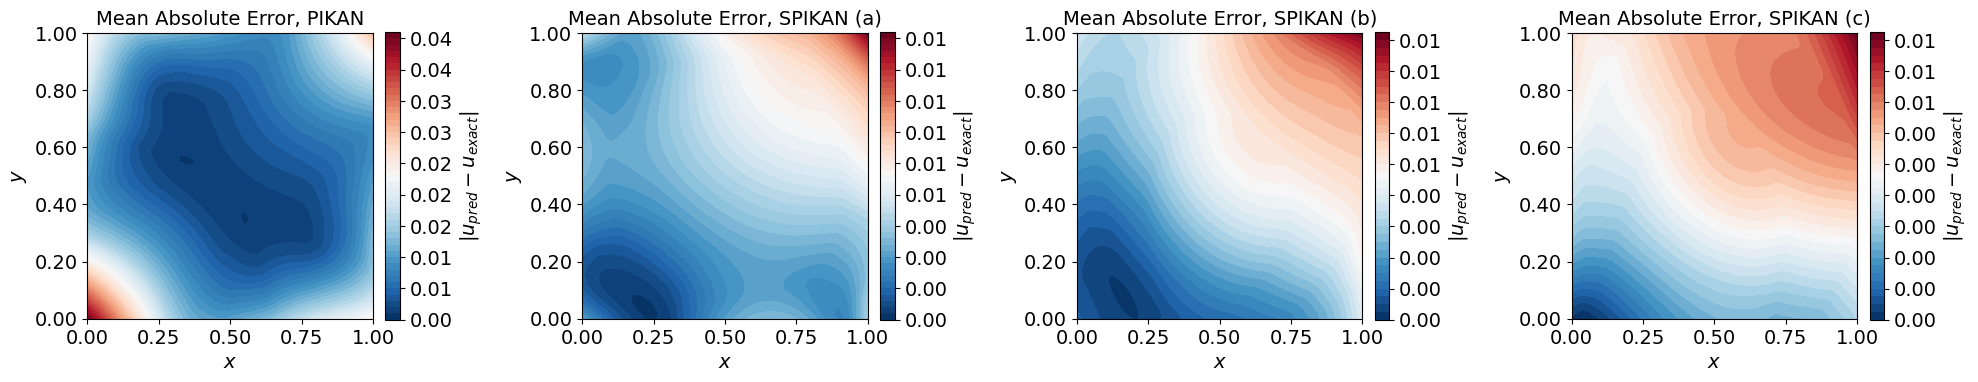

In [78]:
# Create a more compact figure
n_methods = len(solutions)
fig, axes = plt.subplots(1, n_methods, figsize=(5*n_methods, 5))
if n_methods == 1:  # Handle case of single subplot
    axes = [axes]

# Plot absolute error evolution for each method
for ax, (name, sol) in zip(axes, solutions.items()):
    # Compute absolute error for all times
    abs_error = np.abs(sol - u_exact)
    
    # Create time-averaged error plot
    im = ax.contourf(X, Y, np.mean(abs_error, axis=2), levels=50, cmap='RdBu_r')
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(r'$|u_{pred} - u_{exact}|$')
    
    # Calculate average L2 error as percentage
    l2_error = 100 * np.sqrt(np.mean((sol - u_exact)**2)) / np.sqrt(np.mean(u_exact**2))
    
    ax.set_title(f'Mean Absolute Error, {name}')
    ax.set_aspect('equal')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    set_tick_format(ax, cbar)

plt.tight_layout()
plt.savefig('./results/comparison_kleingordon_2d_compact.png', dpi=600, bbox_inches='tight')
plt.show()


In [75]:

# def set_tick_format(ax, cbar, decimals=1):
#     """
#     Set the number of decimal places for x, y, and z ticks on the axis and colorbar.
#     """
#     formatter = ticker.FormatStrFormatter(f'%.{decimals}f')
#     ax.xaxis.set_major_formatter(formatter)
#     ax.yaxis.set_major_formatter(formatter)
#     ax.zaxis.set_major_formatter(formatter)  # Added z-axis formatting
#     cbar.ax.yaxis.set_major_formatter(formatter)

# # Create figure for 3D plots, now with 3 rows for different times
# fig = plt.figure(figsize=(20, 15))
# gs = gridspec.GridSpec(3, 4, width_ratios=[1, 1, 1, 1], wspace=0.4, hspace=0.4)

# # Time points for visualization
# t_values = [0.0, 5.0, 10.0]
# t_indices = [int(t * (nt-1)/T_range[1]) for t in t_values]

# for row, (t_val, t_idx) in enumerate(zip(t_values, t_indices)):
#     # Get reference solution range for this time
#     vmin = np.min(u_exact[:,:,t_idx])
#     vmax = np.max(u_exact[:,:,t_idx])
    
#     # Plot 3D reference solution
#     ax = fig.add_subplot(gs[row, 0], projection='3d')
#     surf = ax.plot_surface(X, Y, u_exact[:,:,t_idx], cmap='RdBu_r',
#                           linewidth=0, antialiased=True,
#                           vmin=vmin, vmax=vmax)
#     cbar = plt.colorbar(surf, ax=ax, fraction=0.035, pad=0.12, label=r'$u$')
#     ax.set_title(f'Reference Solution\nt = {t_val:.1f}')
#     ax.set_xlabel(r'$x$')
#     ax.set_ylabel(r'$y$')
#     ax.set_zlabel(r'$u$')
#     set_tick_format(ax, cbar)
    
#     # Plot each solution
#     for col, (name, sol) in enumerate(solutions.items(), 1):
#         ax = fig.add_subplot(gs[row, col], projection='3d')
#         surf = ax.plot_surface(X, Y, sol[:,:,t_idx], cmap='RdBu_r',
#                               linewidth=0, antialiased=True,
#                               vmin=vmin, vmax=vmax)  # Use same range as reference
#         cbar = plt.colorbar(surf, ax=ax, fraction=0.035, pad=0.12, label=r'$u$')
#         ax.set_title(f'{name}\nt = {t_val:.1f}')
#         ax.set_xlabel(r'$x$')
#         ax.set_ylabel(r'$y$')
#         ax.set_zlabel(r'$u$')
#         set_tick_format(ax, cbar)

# plt.savefig('./results/3d_comparison_kleingordon.png', dpi=600, bbox_inches='tight')
# plt.show()